In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/lab/qm9.pickle', mode='rb') as f:
  df = pickle.load(f)
print(df.head())

      molecule_name  potential_energy SMILES
0  dsgdb9nsd_000001        -40.523680      C
1  dsgdb9nsd_000002        -56.560246      N
2  dsgdb9nsd_000003        -76.426077      O
3  dsgdb9nsd_000004        -77.335268    C#C
4  dsgdb9nsd_000005        -93.428488    C#N


In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y -c rdkit rdkit python=3.7

--2022-01-26 20:06:57--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2022-01-26 20:06:57--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66709754 (64M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  63.62M   289MB/s    in 0.2s    

2022-01-26 20:06:57 (289 MB/s) - ‘Miniconda3-latest-Linux

In [ ]:
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages')

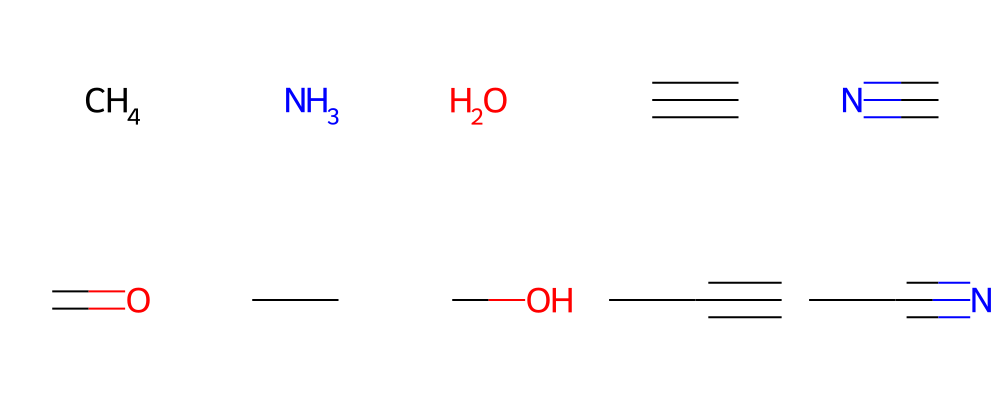

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
mols = [Chem.MolFromSmiles(smile) for smile in df['SMILES']]

Draw.MolsToGridImage(mols[0:10], molsPerRow=5, subImgSize=(200,200))

In [ ]:
import pandas as pd
from rdkit.Chem import AllChem
import numpy as np
fingerprints = []
safe = []
error = []
for mol_idx, mol in enumerate(mols):
    try:
        fingerprint = [x for x in AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2**11)]
        fingerprints.append(fingerprint)
        safe.append(mol_idx)
    except:
        error.append(mol_idx)
        continue
fingerprints = np.array(fingerprints)
print(fingerprints.shape)
pd.DataFrame(fingerprints).head()

df = df.drop(df.index[error])
with open('/content/drive/MyDrive/Colab Notebooks/lab/qm9.pickle', mode='wb') as f:
  pickle.dump(df, f)


(128730, 2048)


In [ ]:
X = np.load("/content/drive/MyDrive/Colab Notebooks/lab/X_2d_qm9.npy")
data_y=df
data_y=data_y.drop("molecule_name", axis=1)
data_y=data_y.drop("SMILES", axis=1)

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from keras.models import Sequential
from keras.layers import Dense, Activation
Y=data_y

Y = np.array(Y, dtype = np.float32)

Ave=Y.mean(axis=0)
Std=Y.std(ddof=1,axis=0)

Y=(Y - Ave) / Std
np.save("/content/drive/MyDrive/Colab Notebooks/lab/Y_2d_qm9.npy", Y)
print(Y)
print(Ave)
print(Std)

[[9.328081  ]
 [8.923618  ]
 [8.422577  ]
 ...
 [0.7435023 ]
 [1.1475921 ]
 [0.24244292]]
[-410.37357]
[39.649086]


In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.20, random_state=20211208)
np.save("/content/drive/MyDrive/Colab Notebooks/lab/X_train_qm9.npy", X_train)
np.save("/content/drive/MyDrive/Colab Notebooks/lab/X_test_qm9.npy", X_test)
np.save("/content/drive/MyDrive/Colab Notebooks/lab/y_train_qm9.npy", y_train)
np.save("/content/drive/MyDrive/Colab Notebooks/lab/y_test_qm9.npy", y_test)

In [ ]:
import numpy as np
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
X_train = np.load("/content/drive/MyDrive/Colab Notebooks/lab/X_train_qm9.npy")
y_train = np.load("/content/drive/MyDrive/Colab Notebooks/lab/y_train_qm9.npy")
X_test = np.load("/content/drive/MyDrive/Colab Notebooks/lab/X_test_qm9.npy")
y_test = np.load("/content/drive/MyDrive/Colab Notebooks/lab/y_test_qm9.npy")

from keras.layers import Input, Dense, Dropout
from keras.models import Model

inputs = Input(shape=(2**11,))

x = Dense(2**10, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
x = Dropout(.2)(x)
x = Dense(2**5, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = Dropout(.2)(x)
x = Dense(2**2, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = Dropout(.2)(x)
predictions = Dense(1, activation="linear")(x)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = Model(inputs=inputs, outputs=predictions)

model.compile(Adam(lr=1e-3), loss="mean_squared_error")

history = model.fit(X_train, y_train, batch_size=128, epochs=2000, validation_data=(X_test, y_test),callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/2000
805/805 [==============================] - 7s 6ms/step - loss: 0.8520 - val_loss: 0.4669
Epoch 2/2000
805/805 [==============================] - 4s 4ms/step - loss: 0.4962 - val_loss: 0.4145
Epoch 3/2000
805/805 [==============================] - 4s 4ms/step - loss: 0.4669 - val_loss: 0.3969
Epoch 4/2000
805/805 [==============================] - 4s 4ms/step - loss: 0.4577 - val_loss: 0.3987
Epoch 5/2000
805/805 [==============================] - 4s 4ms/step - loss: 0.4531 - val_loss: 0.3928
Epoch 6/2000
805/805 [==============================] - 4s 4ms/step - loss: 0.4486 - val_loss: 0.3826
Epoch 7/2000
805/805 [==============================] - 3s 4ms/step - loss: 0.4476 - val_loss: 0.3794
Epoch 8/2000
805/805 [==============================] - 4s 5ms/step - loss: 0.4499 - val_loss: 0.3850
Epoch 9/2000
805/805 [==============================] - 4s 5ms/step - loss: 0.4454 - val_loss: 0.3842
Epoch 10/2000
805/805 [==============================] - 4s 5ms/step - loss: 0.449

805/805 [==============================] - 2s 2ms/step - loss: 0.3750
2乗誤差の平均 0.37504842877388


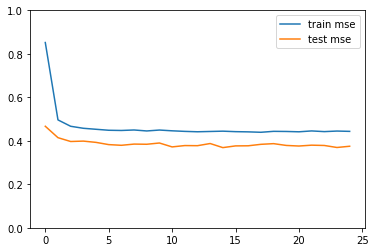

In [ ]:
import matplotlib.pyplot as plt
print('2乗誤差の平均',model.evaluate(X_test, y_test))

train_acc = history.history['loss']
test_acc = history.history['val_loss']

x = np.arange(len(train_acc))
plt.plot(x, train_acc, label = 'train mse')
plt.plot(x, test_acc, label = 'test mse')
plt.ylim(0, 1)
plt.legend()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/lab/202110_qm9_model.h5')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
base_model =load_model('/content/drive/MyDrive/Colab Notebooks/lab/202110_qm9_model.h5')

In [ ]:
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 32)                32800     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0     

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/usr/local/lib/python3.7/site-packages']
2020.09.1


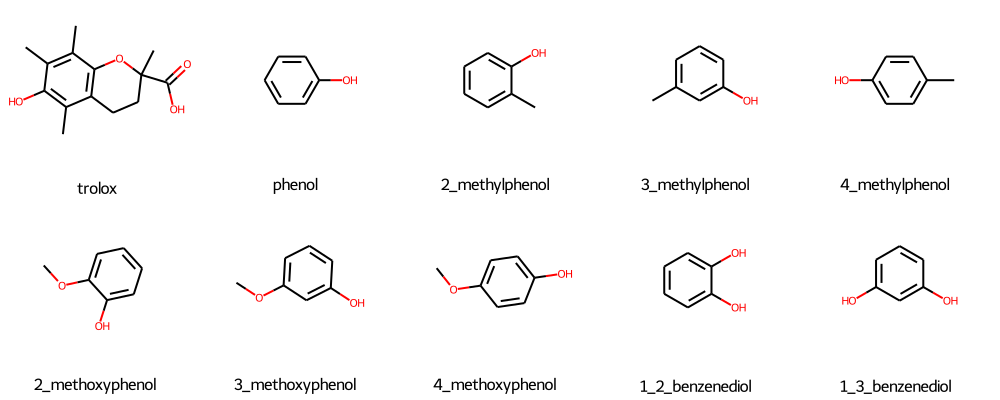

In [ ]:
import sys
import pprint
pprint.pprint(sys.path)
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import rdBase
print(rdBase.rdkitVersion)

import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

dt = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/lab/H_ORAC.csv")
dt.head()

from rdkit import Chem
from rdkit.Chem import Draw
mols = [Chem.MolFromSmiles(smile) for smile in dt['SMILES']]
Name = [x for x in dt['Name']]
L=[]
for i in range(len(Name)):
    legend=Name[i]
    L.append(legend)
Draw.MolsToGridImage(mols[0:10], molsPerRow=5, subImgSize=(200,200), legends=[z for z in L])

In [ ]:
from rdkit.Chem import AllChem
import numpy as np
fingerprints = []
safe = []
for mol_idx, mol in enumerate(mols):
    try:
        fingerprint = [x for x in AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)]
        fingerprints.append(fingerprint)
        safe.append(mol_idx)
    except:
        print("Error", mol_idx)
        continue
fingerprints = np.array(fingerprints)
print(fingerprints.shape)
pd.DataFrame(fingerprints).head()

(70, 2048)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X2=fingerprints
X2 = np.array(X2, dtype = np.float32)
np.save("/content/drive/MyDrive/Colab Notebooks/lab/X_2d_ORAC.npy", X2)
print(X2)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
Y2=[y for y in dt['H_ORAC']]

Y2 = np.array(Y2, dtype = np.float32)

Ave=Y2.mean()
Std=Y2.std(ddof=1)

Y2=(Y2 - Ave )/ Std

np.save("/content/drive/MyDrive/Colab Notebooks/lab/Y_2d_ORAC.npy", Y2)
print(Y2)

[-0.5434038  -0.1577336  -0.45749253 -0.2201499  -0.53286856  0.21718943
  0.517175    0.3992576   0.96539456 -0.06432275  4.858367    0.71591735
  0.86406463 -0.3478773   0.12073161  0.54230046  0.29801032  0.2953972
  0.8034653  -0.92614245 -0.235798    0.6265299  -0.80607396 -0.5244356
 -0.61346394 -0.62144846 -0.61873865 -0.31283364 -1.0512096  -1.0507561
 -1.0488456   0.26605016  0.05566086 -0.92539907 -0.03932004 -0.99443716
 -0.28263178 -0.77516484 -0.559626   -0.6305682  -0.45141768 -0.3848276
 -0.42543682 -0.5228378   2.7227314  -0.78508466 -1.0499865  -0.02662846
 -0.7496714   1.2863741   1.7340133  -0.47654933  1.5442306  -0.13065857
 -0.8465681   0.31667623 -0.7957791  -0.66367626  0.6136809   1.1964297
  1.6072878   1.611745    0.02019791 -0.14124039 -0.8637594  -0.9887596
  0.99622774 -0.4986037  -0.91868335 -0.13418403]


In [ ]:
from keras.models import Model
from tensorflow import keras
import numpy as np
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.layers import Activation, Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam

xx = base_model.output
xx = Dense(2**5, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001))(xx)
xx = Dropout(.2)(xx)
xx = Dense(2**2, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001))(xx)
xx = Dropout(.2)(xx)

predictions = Dense(1, activation='linear')(xx)

model2 = Model(inputs=base_model.input, outputs=predictions)
model2.layers.pop(-9)

model2.compile(Adam(lr=1e-3), loss="mean_squared_error")

model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 32)                32800     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/2000
1/1 [==============================] - 1s 938ms/step - loss: 1.2873 - val_loss: 1.0327
Epoch 2/2000
1/1 [==============================] - 0s 26ms/step - loss: 1.2773 - val_loss: 1.0028
Epoch 3/2000
1/1 [==============================] - 0s 27ms/step - loss: 1.4133 - val_loss: 0.9758
Epoch 4/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.1128 - val_loss: 0.9439
Epoch 5/2000
1/1 [==============================] - 0s 25ms/step - loss: 1.2148 - val_loss: 0.9038
Epoch 6/2000
1/1 [==============================] - 0s 30ms/step - loss: 1.0797 - val_loss: 0.8556
Epoch 7/2000
1/1 [==============================] - 0s 27ms/step - loss: 1.0789 - val_loss: 0.8122
Epoch 8/2000
1/1 [==============================] - 0s 37ms/step - loss: 1.0516 - val_loss: 0.7730
Epoch 9/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.9959 - val_loss: 0.7395
Epoch 10/2000
1/1 [==============================] - 0s 32ms/step - loss: 1.0179 - val_loss: 0.7103
Epoch 11

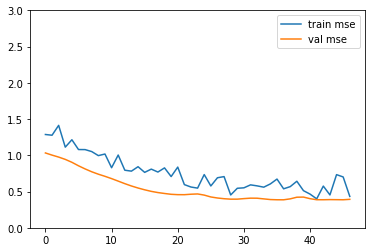

In [ ]:
X2_train, X2_test, y2_train, y2_test = model_selection.train_test_split(X2, Y2, test_size=0.20, random_state=20211208)
np.save("/content/drive/MyDrive/Colab Notebooks/lab/X2_train_t.npy", X2_train)
np.save("/content/drive/MyDrive/Colab Notebooks/lab/X2_test_t.npy", X2_test)
np.save("/content/drive/MyDrive/Colab Notebooks/lab/y2_train_t.npy", y2_train)
np.save("/content/drive/MyDrive/Colab Notebooks/lab/y2_test_t.npy", y2_test)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history2 = model2.fit(X2_train, y2_train, batch_size=128, epochs=2000, validation_data=(X2, Y2),callbacks=[early_stop])
import matplotlib.pyplot as plt
print('2乗誤差の平均',model2.evaluate(X2_test, y2_test))

train_acc = history2.history['loss']
test_acc = history2.history['val_loss']

x = np.arange(len(train_acc))
plt.plot(x, train_acc, label = 'train mse')
plt.plot(x, test_acc, label = 'val mse')
plt.ylim(0, 3)
plt.legend()

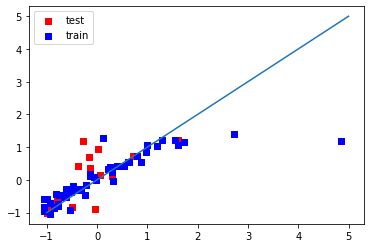

In [ ]:

Y2_pred_t = model2.predict(X2_test)
Y2_train_pred_t = model2.predict(X2_train)
plt.scatter(y2_test, Y2_pred_t, c='r', marker='s',label="test")
plt.scatter(y2_train, Y2_train_pred_t, c='b', marker='s',label="train")
plt.legend()
plt.plot([-1,5],[-1,5])

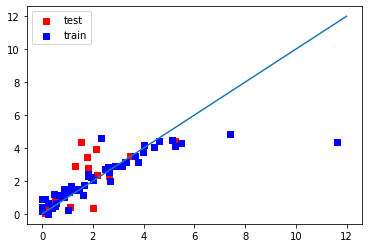

In [ ]:
y2_test=y2_test*Std+Ave
Y2_train_pred_t=Y2_train_pred_t*Std+Ave
y2_train=y2_train*Std+Ave
Y2_pred_t=Y2_pred_t*Std+Ave
plt.scatter(y2_test, Y2_pred_t, c='r', marker='s',label="test")
plt.scatter(y2_train, Y2_train_pred_t, c='b', marker='s',label="train")
plt.legend()
plt.plot([0,12],[0,12])

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
print(mean_squared_error(y2_test, Y2_pred_t))
print(mean_squared_error(y2_train, Y2_train_pred_t))

1.5600498
1.3368394
